In [1]:
import pandas as pd
from pathlib import Path
import statsmodels.formula.api as sm
import numpy as np
import patsy

In [2]:
interim = '../data/interim'

In [3]:
gl = pd.read_pickle(Path(interim) / 'game_logs.pkl')
gl = gl.loc[:, ['GAME_ID', 'HomeH', 'VisitorH', 'ParkID', 'HomeTeam', 'VisitingTeam', 'year']]
gl = gl.astype({
    'HomeH': 'float', 
    'VisitorH': 'float', 
    'ParkID': 'object', 
    'HomeTeam':'object', 
    'VisitingTeam': 'object',
})
gl = gl.rename(columns={
    'HomeH': 'H_Home',
    'VisitorH': 'H_Visitor',
})
gl = gl.dropna()

gl = pd.wide_to_long(
    gl , 
    ['H'] , 
    i=['GAME_ID', 'year', 'HomeTeam', 'VisitingTeam'], 
    j='Home', 
    sep='_', 
    suffix=r'\w+'
)

gl = gl.reset_index().set_index(['GAME_ID'])
gl['BatTeam'] = np.where(
    gl['Home'] == 'Home',
    gl['HomeTeam'],
    gl['VisitingTeam']
)
gl['FieldTeam'] = np.where(
    gl['Home'] == 'Home',
    gl['VisitingTeam'],
    gl['HomeTeam']
)

gl = gl[['year', 'ParkID', 'H', 'BatTeam', 'FieldTeam']]

# gl['LogH'] = np.log(gl['H'])

In [4]:
park_factors = pd.DataFrame(columns=['ParkID', 'factor', 'year'])

max_year = gl.year.max() + 1
min_year = gl.year.min()
for year in range(1920, max_year):
    gl_year = gl.loc[gl.year == year]

    result = sm.ols(formula="H ~ C(ParkID) + C(BatTeam) + C(FieldTeam)", data=gl_year).fit()

    test = pd.DataFrame(result.params)
    test = test.reset_index()
    test.columns = ['ParkID', 'factor']


    ParkFactors = test.loc[test.ParkID.str.contains('ParkID'), ['ParkID', 'factor']]

    ParkFactors['ParkID'] = ParkFactors.ParkID.str.slice(start=-6, stop=-1)

    mat = patsy.dmatrix("C(ParkID)", gl_year)
    di = mat.design_info
    fi = di.factor_infos
    fi2 = fi[list(di.factor_infos.keys())[0]]
    omitted = fi2.categories[0]
    
    ParkFactors = ParkFactors.append({'ParkID':omitted, 'factor':0}, ignore_index=True)
    
    ParkFactors['year'] = year
    
    park_factors = park_factors.append(ParkFactors)
    
    
    
park_factors = park_factors.sort_values(['ParkID', 'year'])
park_factors = park_factors.set_index(['ParkID', 'year'])

ObsCount = gl.groupby(['ParkID', 'year'])[['ParkID']].count()
ObsCount.columns = ['N']

park_factors = pd.merge(park_factors, ObsCount, on=['ParkID', 'year'])

In [5]:
park_factors = park_factors.sort_values(['ParkID', 'year'])

In [6]:
park_factors['lag_factor'] = park_factors.groupby('ParkID')['factor'].shift(1)

In [7]:
result = sm.ols(formula="factor ~ lag_factor", data=park_factors).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 factor   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     521.6
Date:                Mon, 22 Mar 2021   Prob (F-statistic):          1.48e-103
Time:                        14:17:37   Log-Likelihood:                -2427.5
No. Observations:                2154   AIC:                             4859.
Df Residuals:                    2152   BIC:                             4870.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0513      0.016      3.160      0.0

<AxesSubplot:xlabel='lag_factor', ylabel='factor'>

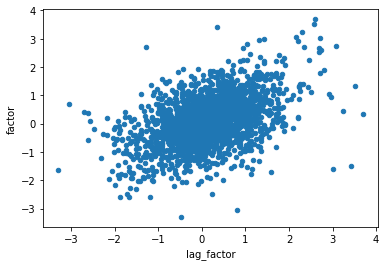

In [8]:
park_factors.plot.scatter(x='lag_factor', y='factor')